# Setup

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from collections import deque
import numpy as np
import random
import gym
from gym import logger
import wandb
from wandb.keras import WandbCallback

run = wandb.init(
    config={
        "gamma": 0.99, 
        "epsilon": 1,
        "epsilon_min": 0.1,
        "target_reward": 400.0,
        "batch_size": 64,
        "win_trials": 100,
        "units": 256,
        "learning_rate": 0.001
        },
    project="cartpole-v2")


episode_score,▁▃▄▄█
epoch,▁▁▁
epsilon,███████████████▆▆▆▆▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁
loss,██▁
episode_score,33.8
epoch,0
epsilon,0.98628
loss,0.47423


wandb: WARNING Upgrade to the 0.9.48 version of W&B Local to get the latest features. Learn more: http://wandb.me/local-upgrade


# DQN Agent

In [28]:
class DQNAgent:
    def __init__(self,
                 state_space, 
                 action_space, 
                 episodes=500):
        """DQN Agent on CartPole-v0 environment

        Arguments:
            state_space (tensor): state space
            action_space (tensor): action space
            episodes (int): number of episodes to train
        """
        self.action_space = action_space

        # experience buffer
        self.memory = []

        # discount rate
        self.gamma = run.config.gamma

        # initially 90% exploration, 10% exploitation
        self.epsilon = run.config.epsilon
        # iteratively applying decay til 
        # 10% exploration/90% exploitation
        self.epsilon_min = run.config.epsilon_min
        self.epsilon_decay = self.epsilon_min / self.epsilon
        self.epsilon_decay = self.epsilon_decay ** \
                             (1. / float(episodes))

        # Q Network weights filename
        self.weights_file = 'dqn_cartpole.h5'
        # Q Network for training
        n_inputs = state_space.shape[0]
        n_outputs = action_space.n
        self.q_model = self.build_model(n_inputs, n_outputs)
        self.q_model.compile(loss='mae', optimizer=Adam(learning_rate=run.config.learning_rate))
        # target Q Network
        self.target_q_model = self.build_model(n_inputs, n_outputs)
        # copy Q Network params to target Q Network
        self.update_weights()

        self.replay_counter = 0

    
    def build_model(self, n_inputs, n_outputs):
        inputs = Input(shape=(n_inputs, ), name='state')
        x = Dense(run.config.units, activation='relu')(inputs)
        x = Dense(run.config.units, activation='relu')(x)
        x = Dense(run.config.units, activation='relu')(x)
        x = Dense(n_outputs,
                  activation='linear', 
                  name='action')(x)
        q_model = Model(inputs, x)
        q_model.summary()
        return q_model


    def save_weights(self):
        """save Q Network params to a file"""
        self.q_model.save_weights(self.weights_file)


    def update_weights(self):
        """copy trained Q Network params to target Q Network"""
        self.target_q_model.set_weights(self.q_model.get_weights())


    def act(self, state):
        """eps-greedy policy
        Return:
            action (tensor): action to execute
        """
        run.log({"epsilon":self.epsilon})
        if np.random.rand() < self.epsilon or episode_count<20:
            # explore - do random action
            return self.action_space.sample()
        # exploit
        q_values = self.q_model.predict(state)
        # select the action with max Q-value
        action = np.argmax(q_values[0])
        return action


    def remember(self, state, action, reward, next_state, done):
        """store experiences in the replay buffer
        Arguments:
            state (tensor): env state
            action (tensor): agent action
            reward (float): reward received after executing
                action on state
            next_state (tensor): next state
        """
        item = (state, action, reward, next_state, done)
        self.memory.append(item)


    def get_target_q_value(self, next_state, reward):
        """compute Q_max
           Use of target Q Network solves the 
            non-stationarity problem
        Arguments:
            reward (float): reward received after executing
                action on state
            next_state (tensor): next state
        Return:
            q_value (float): max Q-value computed
        """
        # max Q value among next state's actions
        # DQN chooses the max Q value among next actions
        # selection and evaluation of action is 
        # on the target Q Network
        # Q_max = max_a' Q_target(s', a')
        q_value = np.amax(\
                     self.target_q_model.predict(next_state)[0])

        # Q_max = reward + gamma * Q_max
        q_value *= self.gamma
        q_value += reward
        return q_value


    def replay(self, batch_size):
        """experience replay addresses the correlation issue 
            between samples
        Arguments:
            batch_size (int): replay buffer batch 
                sample size
        """
        # sars = state, action, reward, state' (next_state)
        sars_batch = random.sample(self.memory, batch_size)
        state_batch, q_values_batch = [], []

        # fixme: for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for state, action, reward, next_state, done in sars_batch:
            # policy prediction for a given state
            q_values = self.q_model.predict(state)
            
            # get Q_max
            q_value = self.get_target_q_value(next_state, reward)

            # correction on the Q value for the action used
            q_values[0][action] = reward if done else q_value

            # collect batch state-q_value mapping
            state_batch.append(state[0])
            q_values_batch.append(q_values[0])

        # train the Q-network
        self.q_model.fit(np.array(state_batch),
                         np.array(q_values_batch),
                         batch_size=batch_size,
                         verbose=0,
                         epochs=1,
                         callbacks=WandbCallback())
                

        # update exploration-exploitation probability
        self.update_epsilon()

        # copy new params on old target after 
        # every 10 training updates
        if self.replay_counter % 10 == 0:
            self.update_weights()

        self.replay_counter += 1

    
    def update_epsilon(self):
        """decrease the exploration, increase exploitation"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        

# DDQN Agent (Not in use)

In [29]:
class DDQNAgent(DQNAgent):
    def __init__(self,
                 state_space, 
                 action_space, 
                 episodes=500):
        super().__init__(state_space, 
                         action_space, 
                         episodes)
        """DDQN Agent on CartPole-v0 environment

        Arguments:
            state_space (tensor): state space
            action_space (tensor): action space
            episodes (int): number of episodes to train
        """

        # Q Network weights filename
        self.weights_file = 'ddqn_cartpole.h5'
        print("-------------DDQN------------")

    def get_target_q_value(self, next_state, reward):
        """compute Q_max
           Use of target Q Network solves the 
            non-stationarity problem
        Arguments:
            reward (float): reward received after executing
                action on state
            next_state (tensor): next state
        Returns:
            q_value (float): max Q-value computed
        """
        # max Q value among next state's actions
        # DDQN
        # current Q Network selects the action
        # a'_max = argmax_a' Q(s', a')
        action = np.argmax(self.q_model.predict(next_state)[0])
        # target Q Network evaluates the action
        # Q_max = Q_target(s', a'_max)
        q_value = self.target_q_model.predict(\
                                      next_state)[0][action]

        # Q_max = reward + gamma * Q_max
        q_value *= self.gamma
        q_value += reward
        return q_value


# Training

In [30]:
if __name__ == '__main__':
    

    # the number of trials without falling over
    win_trials = run.config.win_trials
    # the CartPole-v0 is considered solved if 
    # for 100 consecutive trials, he cart pole has not 
    # fallen over and it has achieved an average 
    # reward of 195.0 
    # a reward of +1 is provided for every timestep 
    # the pole remains upright
    win_reward = { 'CartPole-v1' : run.config.target_reward }

    # stores the reward per episode
    scores = deque(maxlen=win_trials)
    rewards_history_full = []
    logger.setLevel(logger.ERROR)
    env = gym.make("CartPole-v1")

    #env.seed(0)

    # instantiate the DQN/DDQN agent

    agent = DQNAgent(env.observation_space, env.action_space)

    # should be solved in this number of episodes
    episode_count = 3000
    state_size = env.observation_space.shape[0]
    batch_size = run.config.batch_size

    # by default, CartPole-v1 has max episode steps = 500
    # you can use this to experiment beyond 500
    # env._max_episode_steps = 4000

    # Q-Learning sampling and fitting
    for episode in range(episode_count):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False
        total_reward = 0
        while not done:
            # in CartPole-v0, action=0 is left and action=1 is right
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            #env.render()
            # in CartPole-v0:
            # state = [pos, vel, theta, angular speed]
            next_state = np.reshape(next_state, [1, state_size])
            # store every experience unit in replay buffer
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        rewards_history_full.append(total_reward)
        print(total_reward)
        # call experience relay
        if len(agent.memory) >= batch_size:
            agent.replay(batch_size)
    
        scores.append(total_reward)
        mean_score = np.mean(scores)
        run.log({"episode_score": mean_score})
        if mean_score >= win_reward["CartPole-v1"] \
                and episode >= win_trials:
            print("Solved in episode %d: \
                   Mean survival = %0.2lf in %d episodes"
                  % (episode, mean_score, win_trials))
            print("Epsilon: ", agent.epsilon)
            agent.save_weights()
            break
        if (episode + 1) % win_trials == 0:
            print("Episode %d: Mean survival = \
                   %0.2lf in %d episodes" %
                  ((episode + 1), mean_score, win_trials))

    # close the env and write monitor result info to disk
  #  artifact = wandb.Artifact("weights_v1", "weights")
  #  artifact.add_file("dqn_cartpole.h5")
  #  run.log_artifact(artifact)
    run.finish()
    env.close() 

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_30 (Dense)            (None, 256)               1280      
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 action (Dense)              (None, 2)                 514       
                                                                 
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
Model: "model_7"
____________________________________

2022-02-20 19:19:08.778898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 19:19:08.816277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 19:19:11.130746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12.0
22.0
12.0
43.0
34.0
29.0
25.0
34.0
25.0
13.0
16.0
21.0
25.0
28.0
20.0
18.0
20.0
17.0
24.0
29.0
14.0
12.0
14.0
13.0
22.0
15.0
19.0
12.0
25.0
9.0
15.0
15.0
27.0
13.0
18.0
12.0
23.0
21.0
15.0
17.0
22.0
14.0
17.0
12.0
10.0
11.0
21.0
13.0
10.0
16.0
14.0
14.0
12.0
17.0
16.0
14.0
10.0
12.0
14.0
10.0
13.0
17.0
12.0
22.0
13.0
12.0
21.0
13.0
8.0
11.0
9.0
17.0
18.0
12.0
8.0
11.0
23.0
16.0
10.0
13.0
16.0
11.0
28.0
24.0
12.0
19.0
12.0
11.0
12.0
17.0
19.0
15.0
10.0
11.0
13.0
16.0
15.0
Episode 100: Mean survival =                    16.83 in 100 episodes
14.0
10.0
10.0
12.0
31.0
11.0
11.0
10.0
9.0
9.0
16.0
10.0
16.0
19.0
18.0
26.0
13.0
12.0
16.0
11.0
16.0
17.0
11.0
17.0
29.0
11.0
10.0
9.0
9.0
15.0
14.0
9.0
11.0
19.0
16.0
15.0
17.0
27.0
15.0
14.0
13.0
9.0
10.0
10.0
10.0
12.0
12.0
9.0
12.0
13.0
11.0
10.0
15.0
14.0
12.0
10.0
13.0
12.0
14.0
11.0
10.0
14.0
11.0
11.0
12.0
12.0
13.0
10.0
10.0
11.0
8.0
15.0
11.0
13.0
10.0
13.0
13.0
13.0
14.0
14.0
11.0
13.0
8.0
11.0
10.0
11.0
12.0
11.0
11.0
10.0
11.0
10.

wandb: WARNING GPU stats error Command '['/Users/roberto/miniforge3/lib/python3.9/site-packages/wandb/bin/apple_gpu_stats', '--json']' died with <Signals.SIGINT: 2>.


KeyboardInterrupt: 

# Xtuf

309.0
236.0
198.0
206.0
209.0
320.0
263.0
202.0
265.0
262.0
202.0
213.0
233.0
310.0
253.0
227.0
225.0
211.0
254.0
198.0


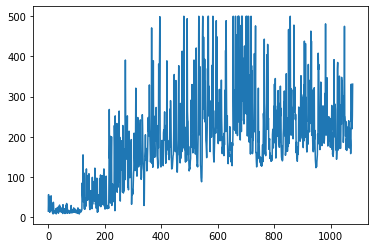

In [ ]:
import matplotlib.pyplot as plt
for i in range(20):
    state = env.reset()
    done = False
    reward_epi = 0
    while not done:
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        q_values = agent.q_model.predict(state_tensor)
        action = np.argmax(q_values[0])
        state, reward, done, info = env.step(action)
        reward_epi += reward
        env.render()
    print(reward_epi)
plt.plot(rewards_history_full)



In [ ]:
agent.q_model.load_weights('/Users/roberto/Projects/final_project/cartpole/dqn_cartpole.h5')
for i in range(20):
    state = env.reset()
    for i in range(200):
        env.render()
        state =  np.reshape(state, [1, state_size])
        action = np.argmax(agent.q_model.predict(state)[0])
        state, reward, done, info = env.step(action)
        
        if done:
            break
        

KeyboardInterrupt: 

Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/Users/roberto/miniforge3/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/Users/roberto/miniforge3/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/roberto/miniforge3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 148, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/Users/roberto/miniforge3/lib/python3.9/site-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/Users/roberto/miniforge3/lib/python3.9/site-packages/wandb/sdk/interface/interface_shared.py", line 388, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "/Users/roberto/miniforge3/lib/python3.9/site-packages/wandb/sdk/interface/interface_shared.py", line 213, in _communicate
 